In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
data = []
labels = []
file_name = []

# Loop melalui setiap subfolder (normal-cecum, polyps, ulcerative-colitis)
for sub_folder in os.listdir("dataset/"):
    sub_folder_path = os.path.join("dataset/", sub_folder)
    
    # Loop melalui setiap file gambar di subfolder
    for filename in os.listdir(sub_folder_path):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv2.imread(img_path) # Baca gambar
        if img is None:  # Skip jika gambar corrupt
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (512, 512)) #Resize gambar ke ukuran tetap agar bisa di-convert ke numpy array

        # Simpan ke list
        data.append(img_resized)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

        
data = np.array(data)
labels = np.array(labels)

In [3]:
def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])
    
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result


sharpen_kernel = np.array([  [-1, -1, -1],
                             [-1,  9, -1],
                             [-1, -1, -1]])

def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)

def masking(channel, mask_median):
    objek = channel.copy()
    objek[mask_median == 0] = 0 

    return objek

kernelElips5x5 = np.array([[0, 0, 1, 0, 0],
                           [0, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 0],
                           [0, 0, 1, 0, 0]], dtype=np.uint8)

In [4]:
def preprocess_2(img):
    img_median = filteringCitra(img, kernel_size=3, filter="median") 
    img_sharp = convo(img_median, sharpen_kernel)
    img_tresh = thresholding(img_sharp, 120, 255, 0)
    opened = opening(img_tresh, kernelElips5x5)
    closed = closing(opened, kernelElips5x5)
    return closed

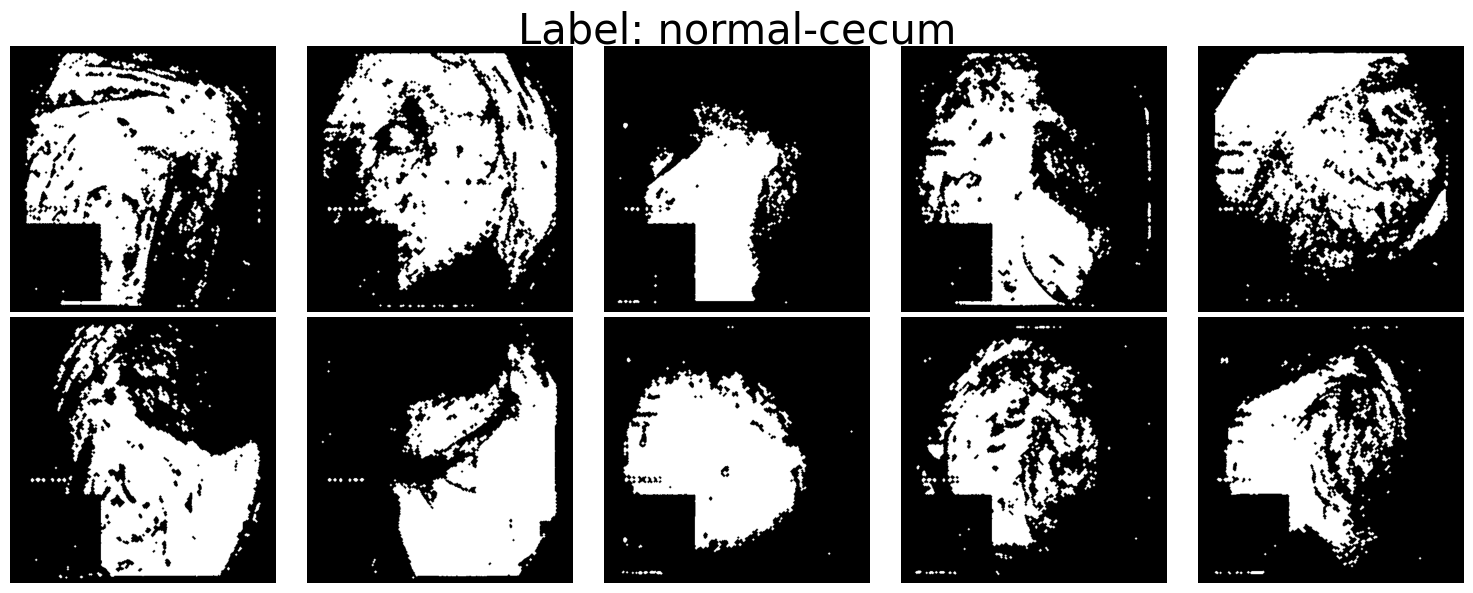

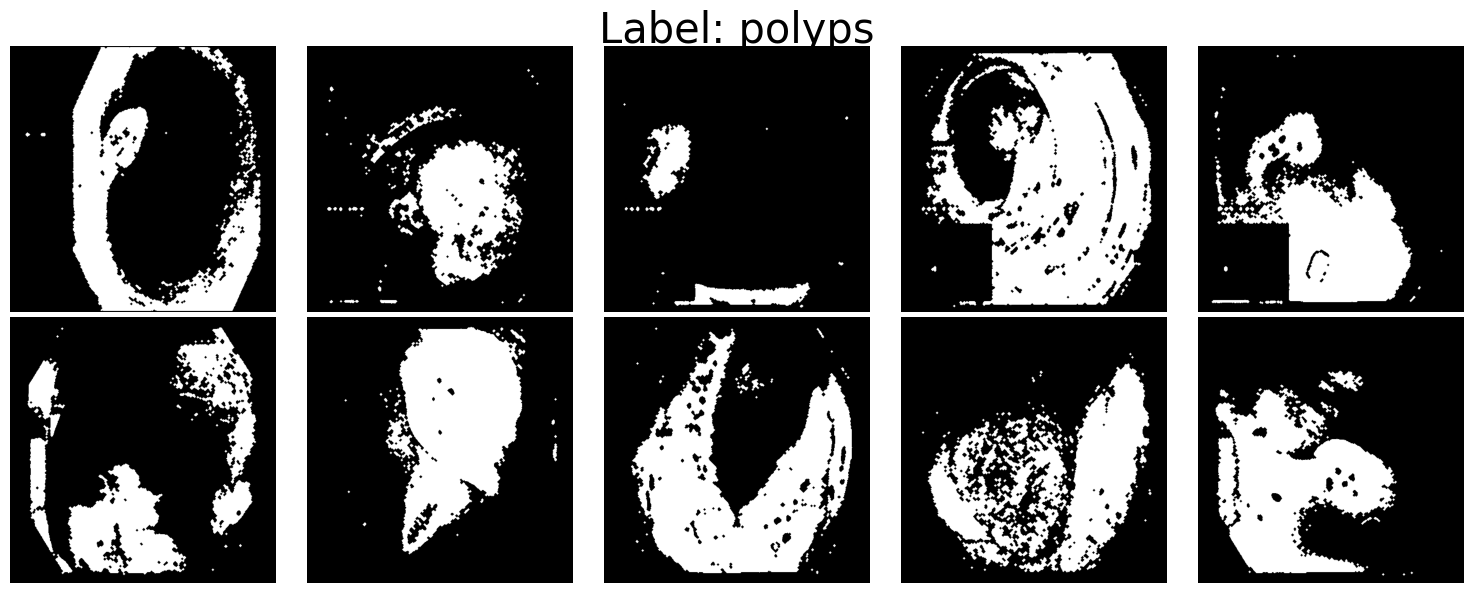

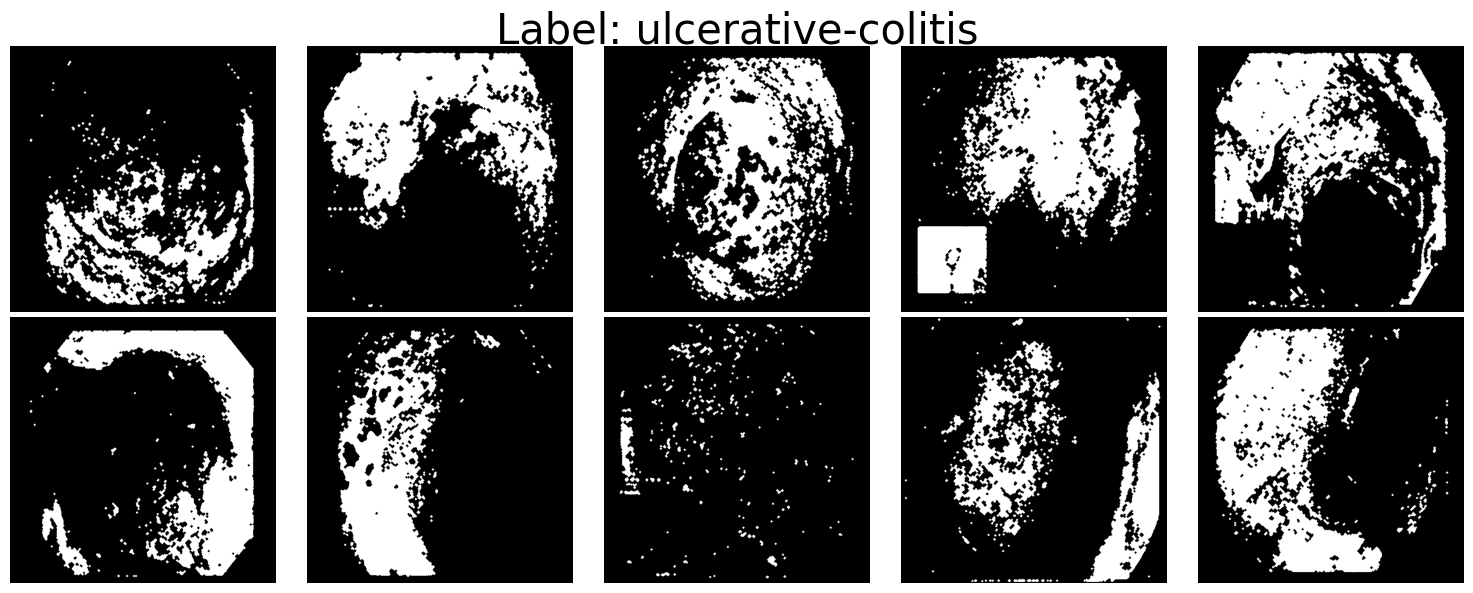

In [5]:
dataPreprocessed2 = [preprocess_2(img) for img in data] 
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 10x10 (cukup untuk 100 gambar, 10*10 = 100)
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Label: {label}', fontsize=30)
    
    for k in range(min(10, len(idxs))):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed2[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed2)):
    D0 = glcm(dataPreprocessed2[i], 0)
    D45 = glcm(dataPreprocessed2[i], 45)
    D90 = glcm(dataPreprocessed2[i], 90)
    D135 = glcm(dataPreprocessed2[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [8]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [9]:
for i in range(len(dataPreprocessed2)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [10]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [11]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [12]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [13]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [14]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [15]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [16]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg,normal-cecum,1873.465211,2197.374397,1897.324677,2105.734123,0.971189,0.966208,0.970822,0.967617,...,0.502366,0.498994,0.709021,0.705463,0.708778,0.706395,0.938609,0.928050,0.937827,0.931051
1,01c49663-9674-44ae-b61e-05243a30e4ab.jpg,normal-cecum,2007.674711,2228.253185,1924.663650,2192.891993,0.969125,0.965733,0.970402,0.966277,...,0.477939,0.473877,0.690463,0.688019,0.691331,0.688387,0.937415,0.930567,0.940003,0.931669
2,01e023db-5c76-4c28-91ab-06e36cd31495.jpg,normal-cecum,716.281074,858.131479,709.819135,772.965790,0.988985,0.986803,0.989084,0.988113,...,0.659274,0.657849,0.811897,0.810292,0.811957,0.811079,0.966613,0.960058,0.966914,0.964022
3,02dcedf1-c0bd-4ef4-b072-ea8f11da6a1d.jpg,normal-cecum,1388.819793,1543.939400,1355.018881,1599.720436,0.978642,0.976257,0.979162,0.975399,...,0.546998,0.542952,0.739256,0.737406,0.739593,0.736853,0.950628,0.945171,0.951830,0.943190
4,032a3076-c75c-4089-a57c-1b19e5f6589e.jpg,normal-cecum,2120.013034,2380.654945,2103.609650,2335.332853,0.967397,0.963389,0.967650,0.964086,...,0.495062,0.491397,0.703439,0.700536,0.703606,0.700997,0.931164,0.922757,0.931697,0.924228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,fc79c489-b358-4368-b965-330615af73d4_00000332.jpg,ulcerative-colitis,1133.821742,1118.110952,1044.348742,1268.022488,0.982564,0.982805,0.983940,0.980500,...,0.845638,0.842072,0.918863,0.918854,0.919586,0.917645,0.874157,0.876123,0.884087,0.859514
296,fc79c489-b358-4368-b965-330615af73d4_00000351.jpg,ulcerative-colitis,2362.584279,2574.394438,2176.182195,2374.180361,0.963667,0.960410,0.966534,0.963489,...,0.747517,0.744317,0.863047,0.861088,0.864591,0.862738,0.834950,0.820453,0.847972,0.834417
297,fc79c489-b358-4368-b965-330615af73d4_00000403.jpg,ulcerative-colitis,1944.049466,2148.067946,1752.179588,2035.509783,0.970104,0.966966,0.973054,0.968697,...,0.709819,0.705295,0.840854,0.838854,0.842508,0.839818,0.886737,0.875050,0.897916,0.881597
298,fc79c489-b358-4368-b965-330615af73d4_00000411.jpg,ulcerative-colitis,1767.588827,2007.619265,1678.115827,1926.935980,0.972817,0.969126,0.974193,0.970367,...,0.635826,0.631731,0.796569,0.794082,0.797387,0.794815,0.919821,0.909062,0.923880,0.912717


<Axes: >

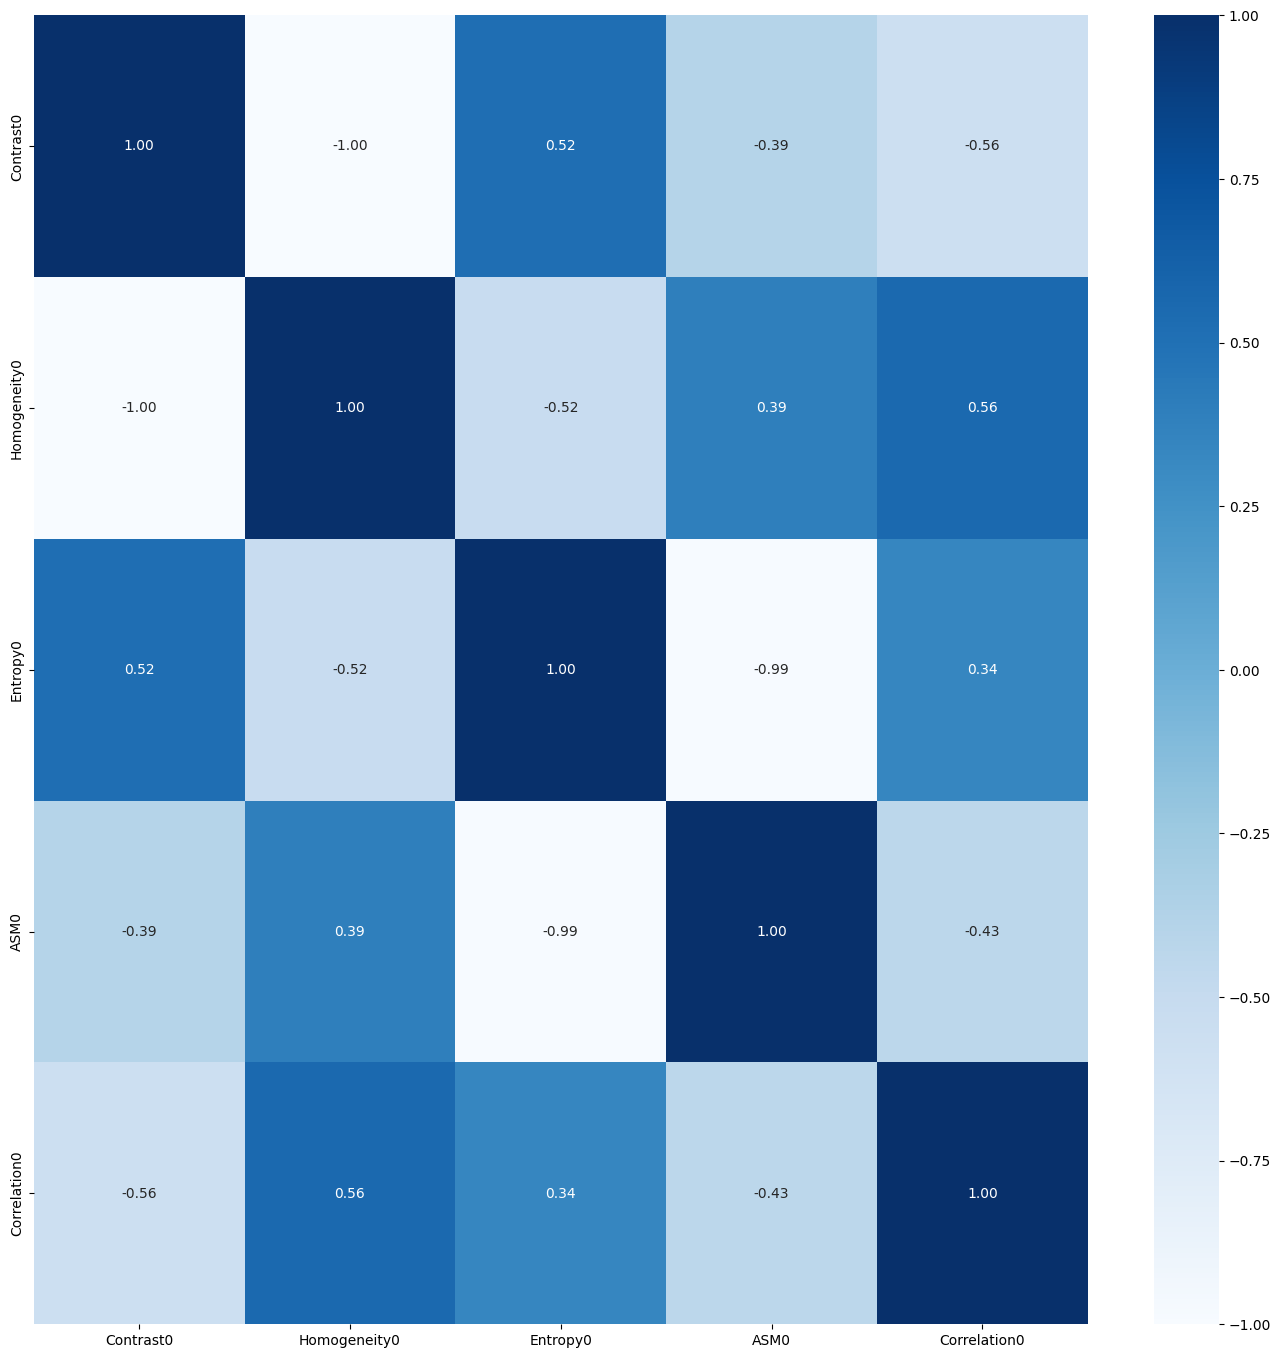

In [17]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [18]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 5)
(60, 5)


In [19]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [20]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.95      0.92      0.94        78
            polyps       0.91      0.95      0.93        84
ulcerative-colitis       0.96      0.94      0.95        78

          accuracy                           0.94       240
         macro avg       0.94      0.94      0.94       240
      weighted avg       0.94      0.94      0.94       240

[[72  4  2]
 [ 3 80  1]
 [ 1  4 73]]
Accuracy: 0.9375

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.44      0.36      0.40        22
            polyps       0.43      0.62      0.51        16
ulcerative-colitis       0.63      0.55      0.59        22

          accuracy                           0.50        60
         macro avg       0.50      0.51      0.50        60
      weighted avg       0.51      0.50      0.50        60

[[ 8  8  6]
 [ 5 10  1]
 [ 5  5 12]]
Accuracy: 0.5

In [22]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.58      0.60      0.59        78
            polyps       0.62      0.71      0.66        84
ulcerative-colitis       0.77      0.62      0.69        78

          accuracy                           0.65       240
         macro avg       0.66      0.64      0.65       240
      weighted avg       0.66      0.65      0.65       240

[[47 21 10]
 [20 60  4]
 [14 16 48]]
Accuracy: 0.6458333333333334

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.57      0.55      0.56        22
            polyps       0.50      0.75      0.60        16
ulcerative-colitis       0.73      0.50      0.59        22

          accuracy                           0.58        60
         macro avg       0.60      0.60      0.58        60
      weighted avg       0.61      0.58      0.58        60

[[12  6  4]
 [ 4 12  0]
 [ 5  6 11]]


In [23]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.64      0.72      0.67        78
            polyps       0.68      0.75      0.72        84
ulcerative-colitis       0.80      0.62      0.70        78

          accuracy                           0.70       240
         macro avg       0.71      0.69      0.70       240
      weighted avg       0.71      0.70      0.70       240

[[56 13  9]
 [18 63  3]
 [14 16 48]]
Accuracy: 0.6958333333333333

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.55      0.50      0.52        22
            polyps       0.46      0.69      0.55        16
ulcerative-colitis       0.75      0.55      0.63        22

          accuracy                           0.57        60
         macro avg       0.59      0.58      0.57        60
      weighted avg       0.60      0.57      0.57        60

[[11  7  4]
 [ 5 11  0]
 [ 4  6 12]]


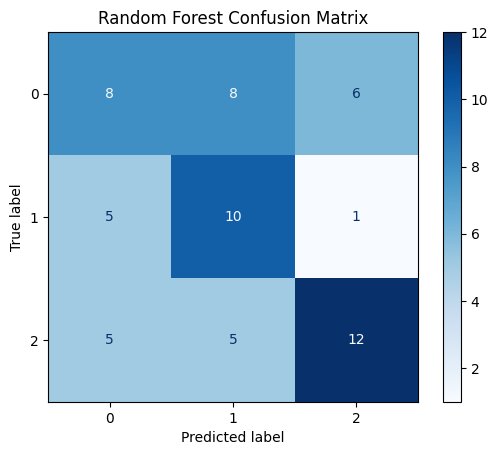

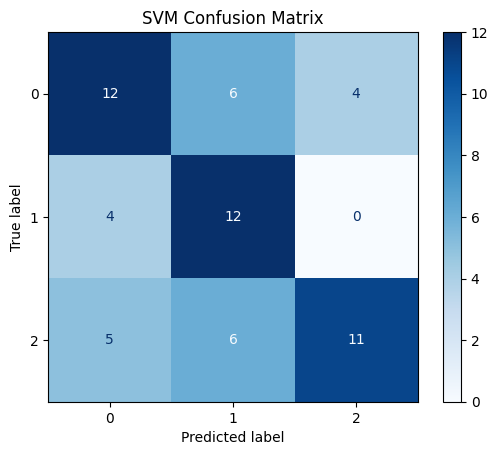

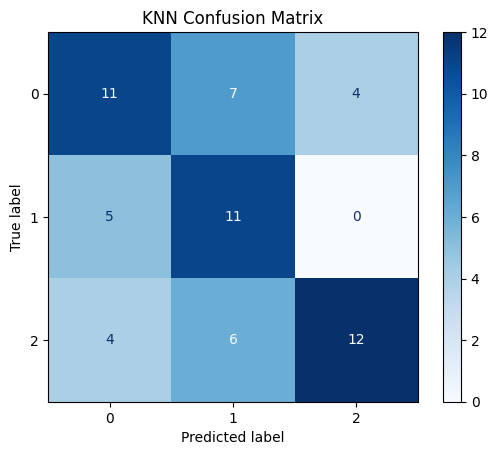

In [24]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")